# GOUT-CC-2020-CORPUS Analysis

###  Requires Physionet de-identified data file GOUT-CC-2020-CORPUS-SYNTHETIC.tsv to run 
### See https://physionet.org/content/emer-complaint-gout/1.0/

## Gout Mention Data Import, Clean and Display

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df = pd.read_csv('GOUT-CC-2020-CORPUS-SYNTHETIC.tsv', delimiter='\t')

print(df)
predict = df['Predict'].value_counts()
print(predict)
consensus = df['Consensus'].value_counts()
print(consensus)


/data/user/ozborn/Conda_Env/deepnlpv2/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


                                        Chief Complaint Predict Consensus
0     "I dont know whats going on with my head, its ...       N         -
1     "i've been depressed for a few weeks now, i'm ...       N         -
2     Altercation while making arrest, c/o R hand pa...       N         N
3     Cut on L upper thigh wtih saw. Bleeding contro...       N         N
4      Dysuria x1 week. hx: hysterectomy, gerd, bipolar       N         -
...                                                 ...     ...       ...
8132  stepped on a nail at home with right foot, pai...       N         N
8133  " I was having a breakdown." R/T stress and de...       N         -
8134  "I tried to jump in front of a car" Pt states ...       N         -
8135                Abdominal pain x 1 week. Denies PMH       N         -
8136  Rash/sores across body, infection ro left thum...       N         N

[8137 rows x 3 columns]
N    7992
U     129
Y      14
-       2
Name: Predict, dtype: int64
-    7873
N     232

## Gout Dictionary

In [12]:
# Gout Body Locations
#Skipping stemming locations, vocabulary is small
goutBodyLocation = ['ARM','HIP','SHOULDER','WRIST','ANKLE','KNEE','TOE','FOOT','FEET','LEG','ELBOW','FINGER','THUMB']
goutBodyLocationAbbreviations = ['LLE','LUE','RUE','RLE','LE','UE']

# Past Medical History
pmhx = ['PMH','PMHX','HX','PMX']

# Gout Keywords from Table 1. https://onlinelibrary.wiley.com/doi/full/10.1002/acr.22324
gout_keywords=['gout','podagra','tophaceous','tophi','tophus']

#Alternative Gout Related Keywords from Table 1. https://onlinelibrary.wiley.com/doi/full/10.1002/acr.22324
alt_keywords=['acute flare','acute inflammatory process','allopurinol','arthritis','attack','big toe','cellulitis',
'codeine','colchicine','chronic arthritis','corticosteroids', 'diclofenac','edema','elevated levels of uric acid',
'flare','flare up','flare‐up','g6pd    ','gonagra','high uric acid level','hydrocodone','hyperuricemia','ibuprofen'
,'indomethacin','inflammation of joint','joint pain','kidney stone','king\'s disease','metacarpal',
'metacarpophalangeal joint','metatarsal phalangeal','metatarsal‐phalangeal','naprosyn','naproxen','nsaid',
'oxycodone','recu    rrent attacks','red joint','redness and swelling','swelling','swollen joint','synovial biopsy',
'synovial fluid analysis','tender joint','urate lower     drugs','urate‐lowering therapy','urate nephropathy',
'uric acid','uric acid crystals','uric crystals','voltarol','zyloric'
]

## Gout Regular Expressions

In [13]:
import re
goutRegex = re.compile('.*gout.*',re.IGNORECASE)

def fetchGoutDictionaryWord(cc):
    if((re.search("|".join(gout_keywords), cc.lower())) !=None):        
        findgoutkeyword = (re.search("|".join(gout_keywords), cc.lower()))
        if(findgoutkeyword!=None):
            #print(findgoutkeyword)
            return findgoutkeyword.group(0);
        return None  

def fetchAltDictionaryWord(cc):
    if((re.search("|".join(alt_keywords), cc.lower())) !=None):        
        findgoutkeyword = (re.search("|".join(alt_keywords), cc.lower()))
        if(findgoutkeyword!=None):
            #print(findgoutkeyword)
            return findgoutkeyword.group(0);
        return None   

def hasGoutKeyword(cc):
    if((re.search("|".join(gout_keywords), cc.lower())) !=None):        
        findgoutkeyword = (re.search("|".join(gout_keywords), cc.lower()))
        if(findgoutkeyword!=None):
            #print(findgoutkeyword)
            return True;
        return False
    
def hasAltGoutKeyword(cc):
    if((re.search("|".join(alt_keywords), cc.lower())) !=None):        
        findgoutkeyword = (re.search("|".join(alt_keywords), cc.lower()))
        if(findgoutkeyword!=None):
            #print(findgoutkeyword)
            return True;
        return False

def hasGoutPmhx(cc):
    if(goutRegex.match(cc)!=None):
        findgout = (re.search('GOUT', cc.upper())).start()
        if((re.search("|".join(pmhx), cc.upper())) !=None):        
            findpmhx = (re.search("|".join(pmhx), cc.upper())).start()
            if(findgout>findpmhx):
                return True
    return False

def hasGoutCurrent(cc):
    if(goutRegex.match(cc)!=None):
        findgout = (re.search('GOUT', cc.upper())).start()
        if((re.search("|".join(pmhx), cc.upper())) !=None):        
            findpmhx = (re.search("|".join(pmhx), cc.upper())).start()
            if(findgout<findpmhx):
                return True
    return False


def hasGoutBodyLocationCurrent(cc):
    goutblmatch = re.search("|".join(goutBodyLocation), cc.upper())
    if(goutblmatch!=None):
        findgoutbl = goutblmatch.start()
        if((re.search("|".join(pmhx), cc.upper())) !=None):        
            findpmhx = (re.search("|".join(pmhx), cc.upper())).start()
            if(findgoutbl<findpmhx):
                return True
    return False

#################################################
# Test Code
assert(hasGoutCurrent('gout flare - pmh DM'))
assert(hasGoutCurrent('bar fight, multiple abrasions - pmhx gout, HT')==False)
assert(hasGoutPmhx('bar fight, multiple abrasions - pmhx gout, HT'))
assert(hasGoutBodyLocationCurrent('knee pain - pmh DM gout'))
#################################################
#Classifiers

# Replication of Stu's results
def regexGoutClassifier(cc):
    if(goutRegex.match(cc)!=None):
        return '__label__Y'
    else:
        return '__label__N'
      
def regexGoutCurrentClassifier(cc):
    if(hasGoutCurrent(cc)):
        return '__label__Y'
    return '__label__N'

def regexGoutKeywordClassifier(cc):
    if(hasGoutKeyword(cc)):
        return '__label__Y'
    return '__label__N'

def regexAltGoutKeywordClassifier(cc):
    if(hasAltGoutKeyword(cc)):
        return '__label__Y'
    return '__label__N'

def regexGoutBodyLocationOrCurrentGoutClassifier(cc):
    if(goutRegex.match(cc)!=None):
        if(hasGoutBodyLocationCurrent(cc)):
            return '__label__Y'
    if(hasGoutCurrent(cc)):
        return '__label__Y'
    return '__label__N'

def regexGoutBodyLocationAndAnyGoutClassifier(cc):
    if(goutRegex.match(cc)!=None):
        if(hasGoutBodyLocationCurrent(cc)):
            return '__label__Y'
    return '__label__N'

#################################################

## Examples of Discrepancies between Prediction and Consensus
### Rheumatologist asserted gout negative based on CC only

In [14]:
df.rename(columns={'Chief Complaint': 'CC'}, inplace=True)


pred = df['Predict'] == 'Y'
con = df['Consensus'] == 'N'
pd.options.display.max_colwidth = 110
disagree = pd.DataFrame(df[pred & con])['CC']
print(disagree)



2158                      Pt states that he has been feeling dizzy for 40 minutes and also c/o leg pain PMH: DM, gout
3477    R big toe swollenx1 week, reports pain as well to R toe, denies any trauma to R foot/toe; PMH: HTN, DM, HL...
3478       R big toe swollen and black x1 week, denies pain. denies any trauma to R foot/toe; PMH: HTN, DM, HLD, gout
4112                                      sent by USA for swelling to L knee sicne this am pmhx: HTN, arthritis, gout
5444        hear for treatment of LLE DVT that was diagnosed 01/23/2000, also c/o pain in buttocks from gout x 2 days
Name: CC, dtype: object


## Body Location Gazeeter Locations extracted from Chief Complaint

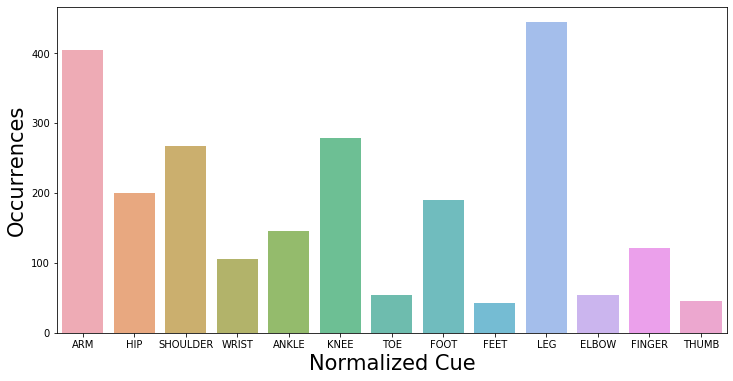

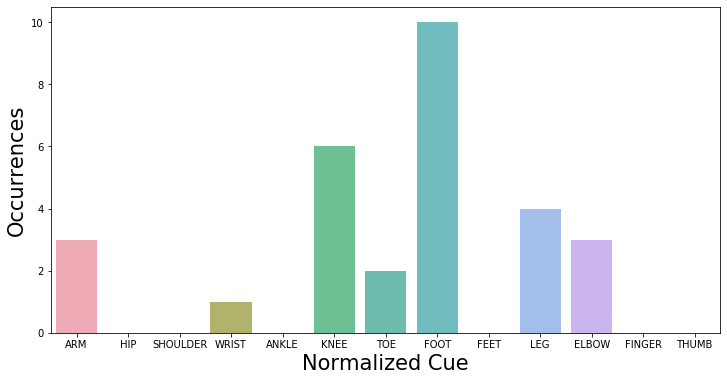

29
199


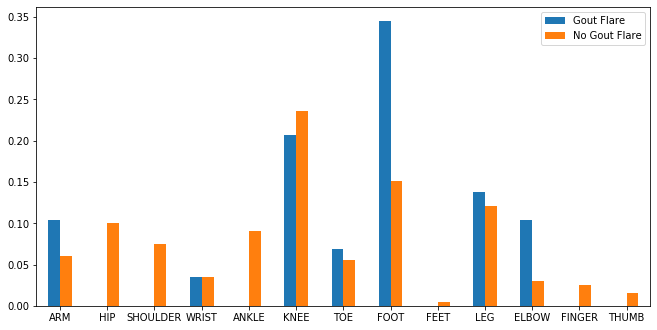

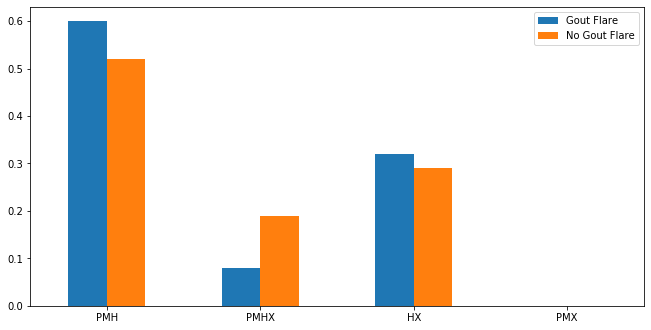

In [6]:
def body2counts(thelist,df,thecase):
    bodydf = pd.DataFrame(df['CC'].copy())
    ccseries = pd.Series(bodydf["CC"])
    counts={}
    for item in thelist:
        bodydf[item] = ccseries.str.contains(item,regex=True,case=thecase)
    for item in thelist:
        countdf = bodydf.loc[bodydf[item] == True]
        counts[item] = len(countdf)   
    return counts



# Plot distribution of body locations in all people
body_count = body2counts(goutBodyLocation,df,False)
bodybits = pd.Series(body_count)
# Plot distribution of PMH
pmh_count = body2counts(pmhx,df,False)
pmhbits = pd.Series(pmh_count)

#print(bodybits)
plt.figure(figsize=(12,6))
sns.barplot(bodybits.index, bodybits.values, alpha=0.8)
#plt.title('Body Location Cues',fontsize='25')
plt.ylabel('Occurrences', fontsize=21)
plt.xlabel('Normalized Cue', fontsize=21)
plt.show()


# SHOW GOUT VS NOT GOUT
goutbitdf = df.loc[df["Consensus"]=='Y']
gout_body_count = body2counts(goutBodyLocation,goutbitdf,False)
goutbodybits = pd.Series(gout_body_count)
plt.figure(figsize=(12,6))
sns.barplot(goutbodybits.index, goutbodybits.values, alpha=0.8)
plt.ylabel('Occurrences', fontsize=21)
plt.xlabel('Normalized Cue', fontsize=21)
plt.show()

notgoutbitdf = df.loc[df["Consensus"]=='N']
notgout_body_count = body2counts(goutBodyLocation,notgoutbitdf,False)
notgoutbodybits = pd.Series(notgout_body_count)

#print(goutbodybits)
index=[*bodybits.keys()]
gout=[*gout_body_count.values()]
notgout=[*notgout_body_count.values()]

goutfolks = 0
notgoutfolks = 0
for num in gout:
    goutfolks = num + goutfolks
for num in notgout:
    notgoutfolks = num + notgoutfolks
print(goutfolks)
print(notgoutfolks)

goutpercent = [x / goutfolks for x in gout]
notgoutpercent = [x / notgoutfolks for x in notgout]

#print(index)
#print(gout)
#print(notgout)
#print(goutpercent)
#print(notgoutpercent)

#goutDifdf = pd.DataFrame({'Gout': gout}, index=index)
#ax = goutDifdf.plot.bar(rot=0)
#goutDifdf = pd.DataFrame({'No Gout': notgout}, index=index)
#ax = goutDifdf.plot.bar(rot=0)
goutDifdf = pd.DataFrame({'Gout Flare': goutpercent,'No Gout Flare': notgoutpercent}, index=index)
ax = goutDifdf.plot.bar(rot=0,figsize=(11,5.5))
#goutDifdf = pd.DataFrame({'Gout Flare': gout,'No Gout Flare': notgout}, index=index)
#ax = goutDifdf.plot.bar(rot=0,figsize=(11,5.5))

#### PMH Gout Chart
index=[*pmhbits.keys()]
gout_pmh_count = body2counts(pmhx,goutbitdf,False)
goutpmhbits = pd.Series(gout_pmh_count)
notgout_pmh_count = body2counts(pmhx,notgoutbitdf,False)
notgoutpmhbits = pd.Series(notgout_pmh_count)
index=[*pmhbits.keys()]
gout=[*gout_pmh_count.values()]
notgout=[*notgout_pmh_count.values()]


goutfolks = 0
notgoutfolks = 0
for num in gout:
    goutfolks = num + goutfolks
for num in notgout:
    notgoutfolks = num + notgoutfolks
#print(goutfolks)
#print(notgoutfolks)
#print((goutfolks+notgoutfolks)/300)
goutpercent = [x / goutfolks for x in gout]
notgoutpercent = [x / notgoutfolks for x in notgout]

#print(index)
#print(gout)
#print(notgout)
goutDifdf = pd.DataFrame({'Gout Flare': goutpercent,'No Gout Flare': notgoutpercent}, index=index)
ax = goutDifdf.plot.bar(rot=0,figsize=(11,5.5))




# Abbreviations
abbr_body_count = body2counts(goutBodyLocationAbbreviations,df,True)
abbrbodybits = pd.Series(abbr_body_count)
#print(abbrbodybits)

## Predicting Flare Gout Status on Chief Complaint with NLP
### Chart Review Consensus Data
### Divide Chart Review Consensus data into validation, train and test sets


In [7]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.2)
pred_labels=['__label__Y','__label__N','__label__U']


#Format data
data = df[['Consensus', 'CC']].rename(columns={"Consensus":"label", "CC":"text"})
pd.options.display.max_colwidth = 60
data['label'] = '__label__' + data['label'].astype(str)
print(data[1:10])

data.iloc[0:int(len(data)*0.8)].to_csv('train.tsv', sep='\t', index = False, header = False)
data.iloc[int(len(data)*0.8):int(len(data)*0.9)].to_csv('test.tsv', sep='\t', index = False, header = False)
data.iloc[int(len(data)*0.9):].to_csv('dev.tsv', sep='\t', index = False, header = False);




        label                                                         text
1  __label__-  "i've been depressed for a few weeks now, i'm also comin...
2  __label__N  Altercation while making arrest, c/o R hand pain, unable...
3  __label__N  Cut on L upper thigh wtih saw. Bleeding controlled and w...
4  __label__-             Dysuria x1 week. hx: hysterectomy, gerd, bipolar
5  __label__-  Dx with pna a month ago, took abx/steroids, now c/o incr...
6  __label__-                                        Elevated blood sugar.
7  __label__N  Generalized pain all over. Patient not answering questio...
8  __label__-  Lac to L thumb from circular saw at 2036. Tdap unknown. ...
9  __label__-  MVC 03/23. Lower back and r arm pain. no LOC, no airbag ...


### Regular Expression Based Prediction of Chart Review Gout Flare Status

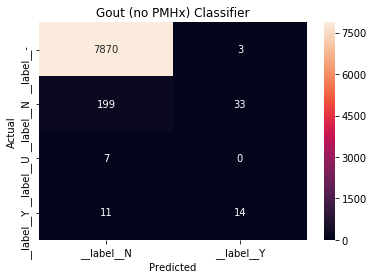

              precision    recall  f1-score   support

  __label__Y       0.28      0.56      0.37        25
  __label__N       0.02      0.86      0.05       232
  __label__U       0.00      0.00      0.00         7

   micro avg       0.03      0.81      0.05       264
   macro avg       0.10      0.47      0.14       264
weighted avg       0.05      0.81      0.08       264



/data/user/ozborn/Conda_Env/deepnlpv2/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


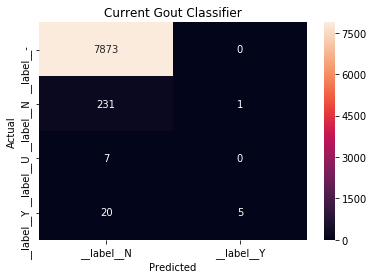

              precision    recall  f1-score   support

  __label__Y       0.83      0.20      0.32        25
  __label__N       0.03      1.00      0.06       232
  __label__U       0.00      0.00      0.00         7

   micro avg       0.03      0.89      0.06       264
   macro avg       0.29      0.40      0.13       264
weighted avg       0.10      0.89      0.08       264



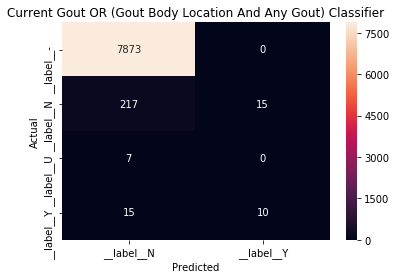

              precision    recall  f1-score   support

  __label__Y       0.40      0.40      0.40        25
  __label__N       0.03      0.94      0.05       232
  __label__U       0.00      0.00      0.00         7

   micro avg       0.03      0.86      0.05       264
   macro avg       0.14      0.45      0.15       264
weighted avg       0.06      0.86      0.08       264



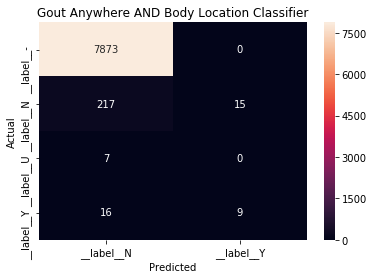

              precision    recall  f1-score   support

  __label__Y       0.38      0.36      0.37        25
  __label__N       0.03      0.94      0.05       232
  __label__U       0.00      0.00      0.00         7

   micro avg       0.03      0.86      0.05       264
   macro avg       0.13      0.43      0.14       264
weighted avg       0.06      0.86      0.08       264



In [8]:
# Test Regular Expression Classifiers
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

def showConfusionMatrix(heading,y_true,y_pred):
    regex1data  = {'y_Actual': y_true,'y_Predicted': y_pred}
    df = pd.DataFrame(regex1data, columns=['y_Actual','y_Predicted'])
    confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'],)
    ax = plt.axes()
    ax = sns.heatmap(confusion_matrix, annot=True,fmt="d",ax=ax)
    ax.set_title(heading)
    plt.show()
    print(classification_report(y_true, y_pred, target_names=pred_labels, labels=pred_labels))


y_true = data['label']
#Current Gout Classifier
y_pred = (pd.DataFrame(data['text']).applymap(regexGoutClassifier))['text']
title2display='Gout (no PMHx) Classifier'
showConfusionMatrix(title2display,y_true,y_pred)

#Current Gout Only Classifier
y_pred = (pd.DataFrame(data['text']).applymap(regexGoutCurrentClassifier))['text']
title2display='Current Gout Classifier'
showConfusionMatrix(title2display,y_true,y_pred)

#Current Gout Or Current Body Location Classifier
y_pred = (pd.DataFrame(data['text']).applymap(regexGoutBodyLocationOrCurrentGoutClassifier))['text']
title2display='Current Gout OR (Gout Body Location And Any Gout) Classifier'
showConfusionMatrix(title2display,y_true,y_pred)

#Gout Or Current Body Location Classifier
y_pred = (pd.DataFrame(data['text']).applymap(regexGoutBodyLocationAndAnyGoutClassifier))['text']
title2display='Gout Anywhere AND Body Location Classifier'
showConfusionMatrix(title2display,y_true,y_pred)



## Regular Expression Based Prediction of Likely Gout Flare Status based on Chief Complaint

        label                                                         text
1  __label__N  "i've been depressed for a few weeks now, i'm also comin...
2  __label__N  Altercation while making arrest, c/o R hand pain, unable...
3  __label__N  Cut on L upper thigh wtih saw. Bleeding controlled and w...
4  __label__N             Dysuria x1 week. hx: hysterectomy, gerd, bipolar
5  __label__N  Dx with pna a month ago, took abx/steroids, now c/o incr...
6  __label__N                                        Elevated blood sugar.
7  __label__N  Generalized pain all over. Patient not answering questio...
8  __label__N  Lac to L thumb from circular saw at 2036. Tdap unknown. ...
9  __label__N  MVC 03/23. Lower back and r arm pain. no LOC, no airbag ...


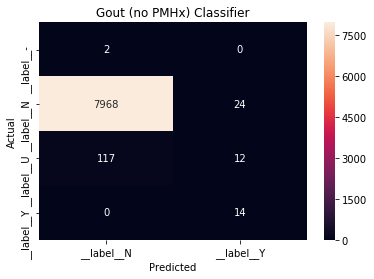

              precision    recall  f1-score   support

  __label__Y       0.28      1.00      0.44        14
  __label__N       0.99      1.00      0.99      7992
  __label__U       0.00      0.00      0.00       129

   micro avg       0.98      0.98      0.98      8135
   macro avg       0.42      0.67      0.48      8135
weighted avg       0.97      0.98      0.97      8135



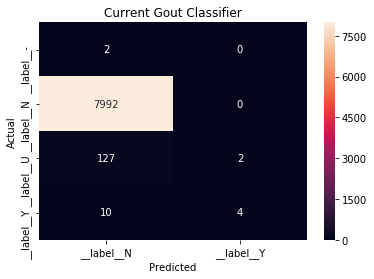

              precision    recall  f1-score   support

  __label__Y       0.67      0.29      0.40        14
  __label__N       0.98      1.00      0.99      7992
  __label__U       0.00      0.00      0.00       129

   micro avg       0.98      0.98      0.98      8135
   macro avg       0.55      0.43      0.46      8135
weighted avg       0.97      0.98      0.97      8135



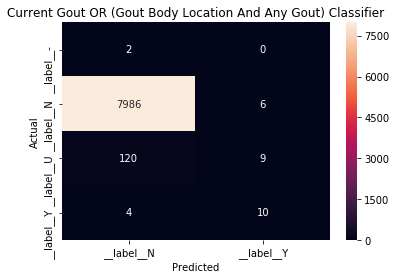

              precision    recall  f1-score   support

  __label__Y       0.40      0.71      0.51        14
  __label__N       0.98      1.00      0.99      7992
  __label__U       0.00      0.00      0.00       129

   micro avg       0.98      0.98      0.98      8135
   macro avg       0.46      0.57      0.50      8135
weighted avg       0.97      0.98      0.98      8135



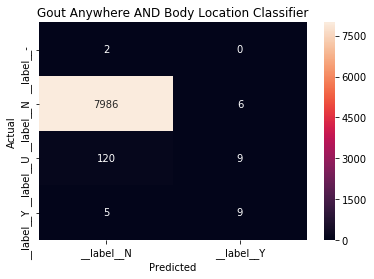

              precision    recall  f1-score   support

  __label__Y       0.38      0.64      0.47        14
  __label__N       0.98      1.00      0.99      7992
  __label__U       0.00      0.00      0.00       129

   micro avg       0.98      0.98      0.98      8135
   macro avg       0.45      0.55      0.49      8135
weighted avg       0.97      0.98      0.98      8135



In [9]:
#Format data
data = df[['Predict', 'CC']].rename(columns={"Predict":"label", "CC":"text"})
pd.options.display.max_colwidth = 60
data['label'] = '__label__' + data['label'].astype(str)
print(data[1:10])

data.iloc[0:int(len(data)*0.8)].to_csv('train.tsv', sep='\t', index = False, header = False)
data.iloc[int(len(data)*0.8):int(len(data)*0.9)].to_csv('test.tsv', sep='\t', index = False, header = False)
data.iloc[int(len(data)*0.9):].to_csv('dev.tsv', sep='\t', index = False, header = False);


y_true = data['label']
#Current Gout Classifier
y_pred = (pd.DataFrame(data['text']).applymap(regexGoutClassifier))['text']
title2display='Gout (no PMHx) Classifier'
showConfusionMatrix(title2display,y_true,y_pred)

#Current Gout Only Classifier
y_pred = (pd.DataFrame(data['text']).applymap(regexGoutCurrentClassifier))['text']
title2display='Current Gout Classifier'
showConfusionMatrix(title2display,y_true,y_pred)

#Current Gout Or Current Body Location Classifier
y_pred = (pd.DataFrame(data['text']).applymap(regexGoutBodyLocationOrCurrentGoutClassifier))['text']
title2display='Current Gout OR (Gout Body Location And Any Gout) Classifier'
showConfusionMatrix(title2display,y_true,y_pred)

#Gout Or Current Body Location Classifier
y_pred = (pd.DataFrame(data['text']).applymap(regexGoutBodyLocationAndAnyGoutClassifier))['text']
title2display='Gout Anywhere AND Body Location Classifier'
showConfusionMatrix(title2display,y_true,y_pred)

## BERT Approach
#### Boilerplate GPU/CUDA Validation

In [9]:
import torch
import sys
print('__Python VERSION:', sys.version)
print('__pyTorch VERSION:', torch.__version__)
print('__CUDA VERSION')
from subprocess import call
# call(["nvcc", "--version"]) does not work
! nvcc --version
print('__CUDNN VERSION:', torch.backends.cudnn.version())
print('__Number CUDA Devices:', torch.cuda.device_count())
print('__Devices')
call(["nvidia-smi", "--format=csv", "--query-gpu=index,name,driver_version,memory.total,memory.used,memory.free"])
print('Active CUDA Device: GPU', torch.cuda.current_device())

print ('Available devices ', torch.cuda.device_count())
print ('Current cuda device ', torch.cuda.current_device())

!conda list | grep torch

__Python VERSION: 3.6.7 |Anaconda, Inc.| (default, Oct 23 2018, 19:16:44) 
[GCC 7.3.0]
__pyTorch VERSION: 1.2.0
__CUDA VERSION
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2018 NVIDIA Corporation
Built on Wed_Apr_11_23:16:29_CDT_2018
Cuda compilation tools, release 9.2, V9.2.88
__CUDNN VERSION: 7602
__Number CUDA Devices: 1
__Devices
Active CUDA Device: GPU 0
Available devices  1
Current cuda device  0
pytorch                   1.2.0           py3.6_cuda9.2.148_cudnn7.6.2_0    pytorch
pytorch-nlp               0.4.1                    pypi_0    pypi


#### BERT Based Prediction of Chart Reviewed Gout Flare Status

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs
        label                                                         text
1  __label__-  "i've been depressed for a few weeks now, i'm also comin...
2  __label__N  Altercation while making arrest, c/o R hand pain, unable...
3  __label__N  Cut on L upper thigh wtih saw. Bleeding controlled and w...
4  __label__-             Dysuria x1 week. hx: hysterectomy, gerd, bipolar
5  __label__-  Dx with pna a month ago, took abx/steroids, now c/o incr...
6  __label__-                                        Elevated blood sugar.
7  __label__N  Generalized pain all over. Patient not answering questio...
8  __label__-  Lac to L thumb from circular saw at 2036. Tdap unknown. ...
9  __label__-  MVC 03/23. Lower back and r arm pain. no LOC, no airbag ...
2020-11-07 16:44:00,126 Reading data from .
2020-11-07 16:44:00,128 Train: train.tsv
2020-11-07 16:44:00,130 Dev: dev.tsv
2020-11-07 16:44:00,132 Test: test.tsv


/data/user/ozborn/Conda_Env/deepnlpv2/lib/python3.6/site-packages/ipykernel_launcher.py:28: DeprecationWarning: Call to deprecated function (or staticmethod) load_classification_corpus. (Use 'flair.datasets' instead.) -- Deprecated since version 0.4.1.
/data/user/ozborn/Conda_Env/deepnlpv2/lib/python3.6/site-packages/flair/data_fetcher.py:452: DeprecationWarning: Call to deprecated function (or staticmethod) read_text_classification_file. (Use 'flair.datasets' instead.) -- Deprecated since version 0.4.1.
  train_file, tokenizer=tokenizer, max_tokens_per_doc=max_tokens_per_doc
/data/user/ozborn/Conda_Env/deepnlpv2/lib/python3.6/site-packages/flair/data_fetcher.py:457: DeprecationWarning: Call to deprecated function (or staticmethod) read_text_classification_file. (Use 'flair.datasets' instead.) -- Deprecated since version 0.4.1.
  test_file, tokenizer=tokenizer, max_tokens_per_doc=max_tokens_per_doc
/data/user/ozborn/Conda_Env/deepnlpv2/lib/python3.6/site-packages/flair/data_fetcher.py:

2020-11-07 16:44:22,836 Computing label dictionary. Progress:


100%|██████████| 6509/6509 [00:00<00:00, 280260.39it/s]

2020-11-07 16:44:22,865 [b'-', b'N', b'Y', b'U']
2020-11-07 16:44:22,882 ----------------------------------------------------------------------------------------------------
2020-11-07 16:44:22,885 Model: "TextClassifier(
  (document_embeddings): DocumentRNNEmbeddings(
    (embeddings): StackedEmbeddings(
      (list_embedding_0): BertEmbeddings(
        (model): BertModel(
          (embeddings): BertEmbeddings(
            (word_embeddings): Embedding(30522, 768, padding_idx=0)
            (position_embeddings): Embedding(512, 768)
            (token_type_embeddings): Embedding(2, 768)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (encoder): BertEncoder(
            (layer): ModuleList(
              (0): BertLayer(
                (attention): BertAttention(
                  (self): BertSelfAttention(
                    (query): Linear(in_features=768, out_features=768, bias

2020-11-07 16:44:22,895 ----------------------------------------------------------------------------------------------------
2020-11-07 16:44:22,897 Corpus: "Corpus: 6509 train + 814 dev + 814 test sentences"
2020-11-07 16:44:22,898 ----------------------------------------------------------------------------------------------------
2020-11-07 16:44:22,900 Parameters:
2020-11-07 16:44:22,901  - learning_rate: "0.1"
2020-11-07 16:44:22,903  - mini_batch_size: "10"
2020-11-07 16:44:22,904  - patience: "5"
2020-11-07 16:44:22,906  - anneal_factor: "0.5"
2020-11-07 16:44:22,907  - max_epochs: "4"
2020-11-07 16:44:22,909  - shuffle: "True"
2020-11-07 16:44:22,910  - train_with_dev: "False"
2020-11-07 16:44:22,912  - batch_growth_annealing: "False"
2020-11-07 16:44:22,913 ----------------------------------------------------------------------------------------------------
2020-11-07 16:44:22,915 Model training base path: "."
2020-11-07 16:44:22,916 ---------------------------------------------

2020-11-07 16:44:23,053 ----------------------------------------------------------------------------------------------------
2020-11-07 16:44:28,337 epoch 1 - iter 65/651 - loss 0.21334940 - samples/sec: 123.10
2020-11-07 16:45:48,736 epoch 1 - iter 130/651 - loss 0.22679896 - samples/sec: 136.88
2020-11-07 16:47:42,113 epoch 1 - iter 195/651 - loss 0.20956856 - samples/sec: 138.00
2020-11-07 16:49:23,029 epoch 1 - iter 260/651 - loss 0.19961401 - samples/sec: 137.17
2020-11-07 16:51:13,161 epoch 1 - iter 325/651 - loss 0.20798956 - samples/sec: 137.31
2020-11-07 16:52:52,911 epoch 1 - iter 390/651 - loss 0.20820160 - samples/sec: 138.04
2020-11-07 16:54:08,152 epoch 1 - iter 455/651 - loss 0.20195305 - samples/sec: 126.11
2020-11-07 16:55:44,026 epoch 1 - iter 520/651 - loss 0.19734429 - samples/sec: 134.59
2020-11-07 16:57:00,863 epoch 1 - iter 585/651 - loss 0.18795328 - samples/sec: 134.17
2020-11-07 16:58:42,634 epoch 1 - iter 650/651 - loss 0.18660295 - samples/sec: 132.39
2020-1

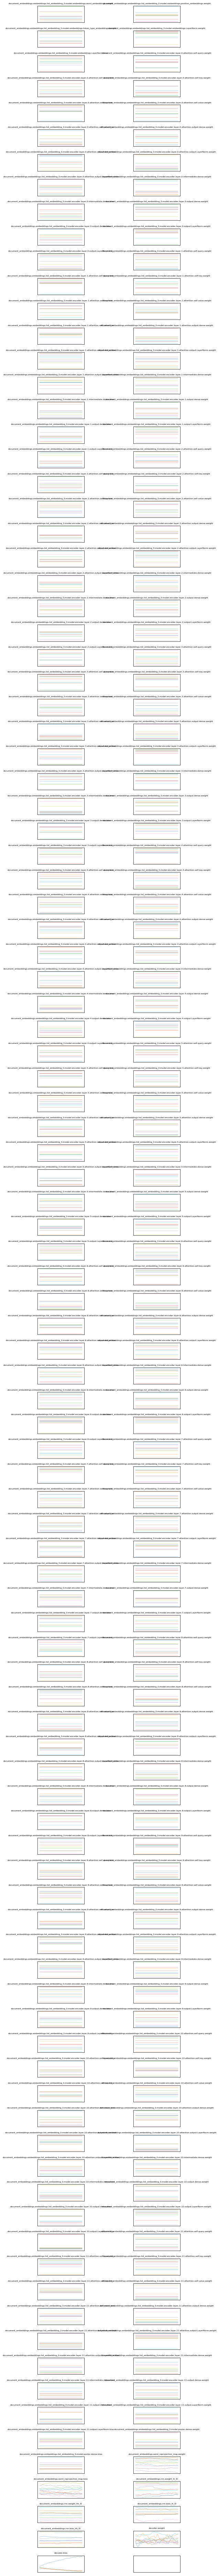

In [11]:
%time
from flair.data_fetcher import NLPTaskDataFetcher
from flair.embeddings import WordEmbeddings, FlairEmbeddings, DocumentRNNEmbeddings
from flair.embeddings import StackedEmbeddings
from flair.embeddings import FlairEmbeddings, BertEmbeddings
from flair.models import TextClassifier
from flair.trainers import ModelTrainer
from pathlib import Path

from flair.data import Corpus

from sklearn.model_selection import train_test_split

# 1. Re/Load Chart Review Data and Format Datda
train, test = train_test_split(df, test_size=0.2)
pred_labels=['__label__Y','__label__N','__label__U']

data = df[['Consensus', 'CC']].rename(columns={"Consensus":"label", "CC":"text"})
pd.options.display.max_colwidth = 60
data['label'] = '__label__' + data['label'].astype(str)
print(data[1:10])
data.iloc[0:int(len(data)*0.8)].to_csv('train.tsv', sep='\t', index = False, header = False)
data.iloc[int(len(data)*0.8):int(len(data)*0.9)].to_csv('test.tsv', sep='\t', index = False, header = False)
data.iloc[int(len(data)*0.9):].to_csv('dev.tsv', sep='\t', index = False, header = False);
df = pd.read_csv('GOUT-CC-2020-CORPUS-SYNTHETIC.tsv', delimiter='\t')

# 2. Create corpus
corpus = NLPTaskDataFetcher.load_classification_corpus(Path('./'), test_file='test.tsv', dev_file='dev.tsv', train_file='train.tsv')

# 3. Train with BERT
word_embeddings = [BertEmbeddings('bert-base-uncased'),                 ]
document_embeddings: DocumentRNNEmbeddings = DocumentRNNEmbeddings(word_embeddings,
                                                                     hidden_size=512,
                                                                     reproject_words=True,
                                                                     reproject_words_dimension=256,
                                                                     )
classifier = TextClassifier(document_embeddings, label_dictionary=corpus.make_label_dictionary())

trainer = ModelTrainer(classifier, corpus)
trainer.train('./', 
              learning_rate=0.1,
              mini_batch_size=10,
              anneal_factor=0.5,
              patience=5,
              max_epochs=4)

# 4. plot weight traces 
from flair.visual.training_curves import Plotter
plotter = Plotter()
plotter.plot_weights('./weights.txt')